In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from formulas import money, plot_loss
ct = lambda x: tf.convert_to_tensor(x, dtype=tf.float32)

In [2]:
ignored_features = ["Photo", "Flag", "Club Logo", "Real Face", "Jersey Number", "Loaned From", "Best Overall Rating", "Joined", "Contract Valid Until", "Nationality", "Club", "Position", "Name", "Preferred Foot", "Work Rate", "Body Type", "Weight", "ID"]

In [3]:
fifa17 = pd.read_csv('../archive/FIFA17_official_data.csv').drop(columns=ignored_features).convert_dtypes()
fifa17["Value"] = fifa17["Value"].apply(money)
fifa17 = fifa17[["Best Position", "Overall", "Value", "Age", "Potential"]]
fifa17 = pd.get_dummies(fifa17, columns=['Best Position'], prefix='', prefix_sep='')

In [4]:
train_dataset = fifa17.sample(frac=0.8, random_state=0)
test_dataset = fifa17.drop(train_dataset.index)

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Potential')
test_labels = test_features.pop('Potential')

train_features = ct(train_features)
test_features = ct(test_features)
train_labels = ct(train_labels)
test_labels = ct(test_labels)

In [6]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [7]:
model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.Dense(672, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
# 
model.compile(loss='huber_loss',
                optimizer=tf.keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 18)               37        
 n)                                                              
                                                                 
 dense (Dense)               (None, 672)               12768     
                                                                 
 dense_1 (Dense)             (None, 1)                 673       
                                                                 
Total params: 13,478
Trainable params: 13,441
Non-trainable params: 37
_________________________________________________________________


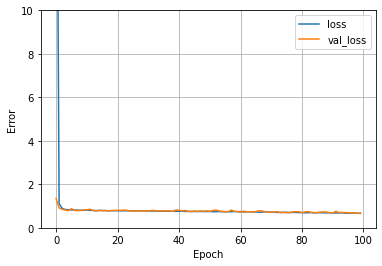

In [8]:
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history)

110/110 [==============================] - 0s 2ms/step


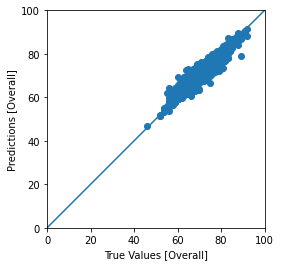

In [9]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Overall]')
plt.ylabel('Predictions [Overall]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

Text(0.5, 0, 'Prediction Error [Overall]')

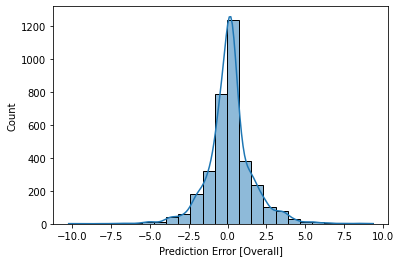

In [10]:
error = test_predictions - ct(test_labels)
g = sns.histplot(error, bins=25, kde=True)
g.set_xlabel("Prediction Error [Overall]")